<a href="https://github.com/jgromero/drl-delve-2024/blob/main/code/cartpole-dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q-Learning for _cartpole_

[**Juan Gómez Romero**](https://decsai.ugr.es/~jgomez)  
Departamento de Ciencias de la Computación e Inteligencia Artificial  
Universidad de Granada  
This work is licensed under the [GNU General Public License v3.0](https://choosealicense.com/licenses/gpl-3.0/).

---
Based on:
> Udacity, Deep Reinforcement Learning Course. Disponible en [GitHub](https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn).

## Configuration

In [1]:
!pip install gymnasium

In [2]:
# set render to 'rgb_array' (change to 'human' for local display-enabled runtime)
render_mode = "rgb_array"

In [3]:
# check whether supporting files exist
import os.path
if not os.path.isfile('dqn_agent.py'):
  !git clone https://github.com/jgromero/drl-delve-2024/
  %cd drl-delve-2024/code

Cloning into 'drl-delve-2024'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 22 (delta 4), reused 17 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 377.71 KiB | 16.42 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/content/drl-delve-2024/code


## Environment

We will be using [CartPole-v1](https://gymnasium.farama.org/environments/classic_control/cart_pole/), a simple control problem.

<img src="https://github.com/jgromero/rl_seminar_2023/blob/main/code/cartpole.gif?raw=true"/>


The action and observation spaces can be printed as follows.

In [5]:
import gymnasium as gym
env = gym.make("CartPole-v1", render_mode = render_mode)
print(env.observation_space)
print(env.action_space)

Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Discrete(2)


We can interact with the environment with an untrained agent by using the `Agent`class in [dqn_agent.py](https://github.com/jgromero/drl-delve-2024/blob/main/code/dqn_agent.py).

In [6]:
from dqn_agent import Agent

agent_untrained = Agent(state_size=4, action_size=2, seed=0)

state, _ = env.reset()

for j in range(200):
    action = agent_untrained.act(state)
    env.render()
    state, reward, done, _, _ = env.step(action)
    if done:
        break

env.close()

## DQN algorithm
Next we provide a generic implementation of Deep Q-Learning (DQN). We rely on external files:

*   [dqn_agent.py](https://github.com/jgromero/drl-delve-2024/blob/main/code/dqn_agent.py): Implementation of the agent capabilities (act, step, etc.)
*   [model.py](): Implementation of the neural network of the agent (the Q-network)

The [CartPole-v1](https://github.com/jgromero/drl-delve-2024/blob/main/code/model.py) environment is solved when the agent obtains more than $195$ points in average for 100 consecutive episodes.

In [7]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

Episode 100	Average score (last 100): 16.70)
Episode 200	Average score (last 100): 11.56)
Episode 300	Average score (last 100): 11.21)
Episode 400	Average score (last 100): 10.35)
Episode 500	Average score (last 100): 10.93)
Episode 600	Average score (last 100): 11.11)
Episode 700	Average score (last 100): 30.39)
Episode 800	Average score (last 100): 83.86)
Episode 900	Average score (last 100): 152.97)

Problem solved in 823 episodes!	Average score (last 100): 196.54)


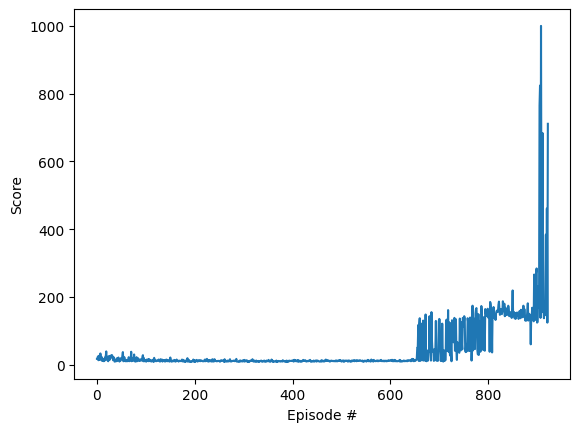

In [8]:
def dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, print_every=100):
    """Deep Q-Learning.

    Params
    ======
        agent (Agent): agent to train
        n_episodes (int): maximum number of episodes (n_episodes)
        max_t (int): maximum number of steps per episode (n_steps)
        eps_start (float): epsilon initial value
        eps_end (float): epsilon final value
        eps_decay (float): multiplication factor for epsilon (per episode)
        print_every (int): print score each print_every episodes
    """
    scores = []                        # scores for every episode
    scores_window = deque(maxlen=100)  # scores for the last episodes (100 by default)
    eps = eps_start                    # initialize epsilon

    for i_episode in range(1, n_episodes+1):
        state, _ = env.reset()
        score = 0

        for t in range(max_t):

            # choose action At with e-greedy policy
            action = agent.act(state, eps)

            # apply At and get Rt+1, St+1
            next_state, reward, done, _, _ = env.step(action)

            # store <St, At, Rt+1, St+1>
            agent.memory.add(state, action, reward, next_state, done)

            # train & update
            agent.step(state, action, reward, next_state, done)

            # advance to next state
            state = next_state
            score += reward

            if done:
                break

        scores_window.append(score)       # save last score (last 100 by default)
        scores.append(score)              # save last score (every episode)
        eps = max(eps_end, eps_decay*eps) # reduce epsilon

        # print training info
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage score (last {:d}): {:.2f})'.format(i_episode, print_every, np.mean(scores_window)))
        if np.mean(scores_window)>=195.0:
            print('\nProblem solved in {:d} episodes!\tAverage score (last {:d}): {:.2f})'.format(i_episode-print_every, print_every, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint-cartpole-dqn.pth') # save weights for trained agent
            break

    return scores

agent = Agent(state_size=4, action_size=2, seed=0)
scores = dqn(agent)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Visualize trained agent

We can afterwards load the weights into the agent and visualize how it acts on the environment. (Local run is required for 2D rendering, not Google Colaboratory.)

In [ ]:
# load weights from `checkpoint.pth`
agent_load = Agent(state_size=4, action_size=2, seed=0)

agent_load.qnetwork_local.load_state_dict(torch.load('checkpoint-cartpole-dqn.pth'))

for i in range(3):
    state, _ = env.reset()
    for j in range(200):
        action = agent_load.act(state)
        env.render()
        state, reward, done, _, _ = env.step(action)
        if done:
            break

env.close()